In [1]:
!tree -L 2

.
├── 2_class.ipynb
├── basic02.ipynb
├── basic.ipynb
├── classification
│   ├── mnist.ipynb
│   └── \347\214\253\345\222\252\350\257\206\345\210\253\345\231\250.ipynb
├── cnn.ipynb
├── Dataset.ipynb
├── datasets
│   ├── air_lake
│   └── flower_photos
├── first.ipynb
├── regression
│   ├── edu_income\347\272\277\346\200\247\345\233\236\345\275\222.ipynb
│   ├── Income1.csv
│   ├── \346\210\277\344\273\267\351\242\204\346\265\213.ipynb
│   ├── \351\235\236\347\272\277\346\200\247\345\233\236\345\275\222.ipynb
│   └── \347\272\277\346\200\247\345\233\236\345\275\222.ipynb
└── Untitled.ipynb

5 directories, 14 files


In [2]:
import tensorflow as tf
import pathlib

In [3]:
data_dir = 'datasets/air_lake'
data_root = pathlib.Path(data_dir)

In [4]:
data_root

PosixPath('datasets/air_lake')

In [5]:
for item in data_root.iterdir():
    print(item)

datasets/air_lake/airplane
datasets/air_lake/lake


In [6]:
all_image_path = list(data_root.glob('*/*'))

In [7]:
all_image_path[:2]

[PosixPath('datasets/air_lake/airplane/airplane_001.jpg'),
 PosixPath('datasets/air_lake/airplane/airplane_002.jpg')]

In [8]:
image_count = len(all_image_path)
image_count

1400

In [9]:
all_image_path[-3:]

[PosixPath('datasets/air_lake/lake/lake_698.jpg'),
 PosixPath('datasets/air_lake/lake/lake_699.jpg'),
 PosixPath('datasets/air_lake/lake/lake_700.jpg')]

In [10]:
all_image_path[:5]

[PosixPath('datasets/air_lake/airplane/airplane_001.jpg'),
 PosixPath('datasets/air_lake/airplane/airplane_002.jpg'),
 PosixPath('datasets/air_lake/airplane/airplane_003.jpg'),
 PosixPath('datasets/air_lake/airplane/airplane_004.jpg'),
 PosixPath('datasets/air_lake/airplane/airplane_005.jpg')]

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['airplane', 'lake']

In [12]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'airplane': 0, 'lake': 1}

In [13]:
index_to_label=dict((index,name) for name,index in label_to_index.items())
index_to_label

{0: 'airplane', 1: 'lake'}

In [14]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_path]

In [15]:
all_image_labels[:3]

[0, 0, 0]

In [16]:
import IPython.display as display

In [17]:
def caption_image(label):
    #return {0: 'airplane', 1: 'lake'}.get(label)
    return index_to_label.get(label)

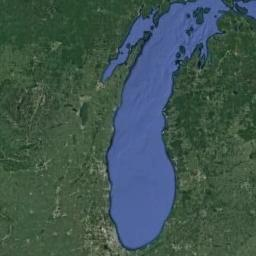

lake



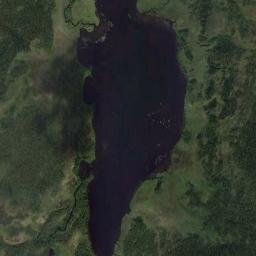

lake



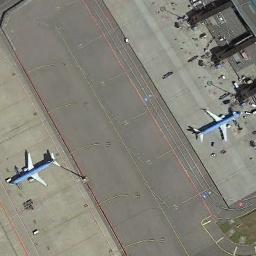

airplane



In [18]:
import random
for n in range(3):
    image_index = random.choice(range(len(all_image_path)))
    display.display(display.Image(str(all_image_path[image_index])))
    print(caption_image(all_image_labels[image_index]))
    print()

In [19]:
all_image_path = [str(x) for x in all_image_path]
img_path = all_image_path

In [20]:
img_raw = tf.io.read_file(img_path[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


In [21]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(256, 256, 3)
<dtype: 'uint8'>


In [22]:
img_tensor = tf.cast(img_tensor, tf.float32)

In [23]:
img_tensor.dtype

tf.float32

In [24]:
img_final = img_tensor/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(256, 256, 3)
0.0
1.0


In [25]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

datasets/air_lake/airplane/airplane_001.jpg



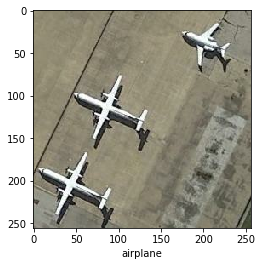

In [26]:
import matplotlib.pyplot as plt

image_path = all_image_path[0]
label = all_image_labels[0]
print(image_path)
plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(label))
print()

In [27]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)

In [28]:
for item in path_ds.take(3):
    print(item.numpy())

b'datasets/air_lake/airplane/airplane_001.jpg'
b'datasets/air_lake/airplane/airplane_002.jpg'
b'datasets/air_lake/airplane/airplane_003.jpg'


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [31]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [32]:
for item in label_ds.take(3):
    print(item.numpy())

0
0
0


In [33]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

airplane
airplane
airplane
airplane
airplane
airplane
airplane
airplane
airplane
airplane


In [34]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [35]:
image_label_ds

<ZipDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int64)>

In [36]:
test_count = int(image_count*0.2)
train_count = image_count - test_count

In [37]:
train_data = image_label_ds.skip(test_count)

test_data = image_label_ds.take(test_count)

In [38]:
BATCH_SIZE = 32

In [40]:
train_dataset = train_data.shuffle(buffer_size=train_count).batch(BATCH_SIZE)

In [43]:
test_dataset = test_data.batch(BATCH_SIZE)

In [44]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [45]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc']
)

In [47]:
steps_per_epoch = train_count//BATCH_SIZE
validation_steps = test_count//BATCH_SIZE

In [ ]:
history = model.fit(train_dataset, epochs=3, steps_per_epoch=steps_per_epoch, validation_data=test_data, validation_steps=validation_steps)

Epoch 1/3
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
